In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Section 1: Data Generation

The goal of this section is to create a dataset with categorical features and a continuous target variable.

First, we create a normal dataset with some preset colinearity, including a target variable. These will simply be used as a base for the categorical variables

In [2]:
corr=.7 # Correlation of target variable to the feature bases
multicol= .4 #Correlation of the feature bases to each other
size = 10000 # number of samples

mvnorm = stats.multivariate_normal(mean=[0, 0, 0, 0, 0], cov=[[1., corr, corr, corr, corr], 
                                                           [corr, 1., multicol, multicol, multicol],
                                                           [corr, multicol, 1., multicol, multicol],
                                                           [corr, multicol, multicol, 1., multicol],
                                                           [corr, multicol, multicol, multicol, 1.]])
raw = mvnorm.rvs(size)

In [3]:
#Add to a dataframe and confirm that the correlations are close
#to our inputs:
normdf = pd.DataFrame(raw)
normdf.columns = ['target', 'norm1', 'norm2', 'norm3', 'norm4']
print(normdf.shape)
normdf.corr()

(10000, 5)


,target,norm1,norm2,norm3,norm4
target,1.000000,0.684491,0.701493,0.693000,0.692358
norm1,0.684491,1.000000,0.384690,0.379049,0.380115
norm2,0.701493,0.384690,1.000000,0.392037,0.395546
norm3,0.693000,0.379049,0.392037,1.000000,0.384047
norm4,0.692358,0.380115,0.395546,0.384047,1.000000


Next, we create some discrete distributions that will represent our categories. By creating different uniform/normalc ombinations as seen below, we ensure that we'll have categories occuring at different frequencies in the dataset.

In [4]:
#Create some categorical features from the feature bases, and sort them 
#The need for sorting will become apparent in a moment
cat1 = np.sort([np.round(x,0) for x in np.random.uniform(high=10.5, low=.5, size=size)])
cat2 = np.sort([np.round(x,0) for x in np.random.uniform(high=5.5, low=.5, size=size)])
cat3 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
cat4 = np.sort([np.ceil(x) for x in np.random.normal(loc=0, scale=2,size=size)])

In [5]:
# #Create some categorical features from the feature bases, and sort them 
# #The need for sorting will become apparent in a moment
# cat1 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
# cat2 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=.5,size=size)])
# cat3 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
# cat4 = np.sort([np.ceil(x) for x in np.random.normal(loc=0, scale=2,size=size)])

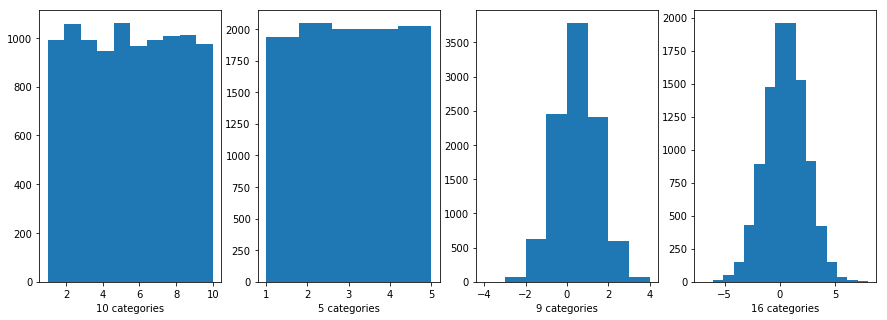

In [6]:
plt.figure(figsize=[15,5])
plt.subplot(141)
plt.hist(cat1, bins=10)
plt.xlabel(str(len(set(cat1)))+" categories")
plt.subplot(142)
plt.hist(cat2, bins=5)
plt.xlabel(str(len(set(cat2)))+" categories")
plt.subplot(143)
plt.hist(cat3, bins=8)
plt.xlabel(str(len(set(cat3)))+" categories")
plt.subplot(144)
plt.hist(cat4, bins=len(set(cat4)))
plt.xlabel(str(len(set(cat4)))+" categories")
plt.show()

By sorting the categories in the same order as the as the normal distributions generated with the multivariate function, we ensure that the categorical features will have a correlation with the target variable.

In [7]:
sortorder1 = stats.rankdata(normdf.norm1, method='ordinal')
sortorder2 = stats.rankdata(normdf.norm2, method='ordinal')
sortorder3 = stats.rankdata(normdf.norm3, method='ordinal')
sortorder4 = stats.rankdata(normdf.norm4, method='ordinal')

In [8]:
generic = pd.DataFrame({
    'target': normdf['target'],
    'feat1' : [int(cat1[i-1]) for i in sortorder1],
    'feat2' : [int(cat2[i-1]) for i in sortorder2],
    'feat3' : [int(cat3[i-1]) for i in sortorder3],
    'feat4' : [int(cat4[i-1]) for i in sortorder4]
})

### Result:
As seen below, the result of the above is a dataframe with 5 categorical variables that have strong correlations with a target variable, and moderate correlations with each other. We will convert the integers to text to obscure these relationships as a way ot simulating a real-life categorical situation.

In [9]:
generic.head()

,target,feat1,feat2,feat3,feat4
0,0.467820,3,5,0,4
1,1.069489,5,5,0,1
2,-0.891430,5,1,0,-1
3,-0.363438,5,2,0,-2
4,0.815818,6,5,1,0


In [10]:
generic.corr()

,target,feat1,feat2,feat3,feat4
target,1.000000,0.661147,0.659495,0.661787,0.683523
feat1,0.661147,1.000000,0.349910,0.345364,0.360526
feat2,0.659495,0.349910,1.000000,0.347652,0.367120
feat3,0.661787,0.345364,0.347652,1.000000,0.362017
feat4,0.683523,0.360526,0.367120,0.362017,1.000000


In [11]:
#confirming the size of the categories we need to fake:
for col in generic.columns[1:]:
    print(col, set(generic[col]))
    print(len(set(generic[col])), "to create")

feat1 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
10 to create
feat2 {1, 2, 3, 4, 5}
5 to create
feat3 {0, 1, 2, 3, 4, -1, -4, -3, -2}
9 to create
feat4 {0, 1, 2, 3, 4, 5, 6, 7, 8, -1, -7, -6, -5, -4, -3, -2}
16 to create


In [52]:
bestmove = ['three', 'layup', 'dunk', 'pass_oop', 'steal',
            'take_charge','midrange','pass_bounce','post_up','free_throw']

position = ['PG', 'SG', 'SF', 'PF', 'C']

sponsors = ['Nike','Reebok','Puma','Adidas','Air_Jordan','Fila','Under_Armour','AND1']

team = ['Knicks','Lakers','Bulls','Thunder','Heat','Clippers','Nets',
        'Rockets','Raptors','Hawks','Warriors','Blazers','Magic','Suns',
        'Celtics','Bobcats','76ers','Kings','Jazz','Spurs', 'Pistons', 'Bucks']

headband = ['Always','Never', 'sometimes']

movie = ['Inception','The_Prestige', 'The Matrix','The_Avengers',
        'Pulp_Fiction','The_GodFather', 'Annihilation','Jaws']

In [53]:
df = pd.DataFrame({
    'all_star_votes': [int(x*10000+1e5) for x in generic['target']],
    'best_move': [bestmove[i-1] for i in generic['feat1']],
    'position': [position[i-1] for i in generic['feat2']],
    'shoe_sponsor': [sponsors[i-1] for i in generic['feat3']],
    'team': [team[i-1] for i in generic['feat4']],
    'wears_headband': [np.random.choice(headband) for _ in range(size)],
    'favorite_movie': [np.random.choice(movie) for _ in range(size)],
})
df.head()

,all_star_votes,best_move,position,shoe_sponsor,team,wears_headband,favorite_movie
0,104678,dunk,C,AND1,Thunder,sometimes,The Matrix
1,110694,steal,C,AND1,Knicks,sometimes,The_Avengers
2,91085,steal,PG,AND1,Pistons,Always,The Matrix
3,96365,steal,SG,AND1,Spurs,Always,Pulp_Fiction
4,108158,take_charge,C,Nike,Bucks,Never,Jaws


# Section 2: PCA vs MCA for dimensionality Reduction with Categorical Variables

### One-hot encoded: Regression Baseline

In [54]:
y = df.all_star_votes
Xcat = df.drop('all_star_votes', axis=1)
X = pd.get_dummies(Xcat, drop_first=True)
print(X.shape)
X.head()

(10000, 44)


,best_move_free_throw,best_move_layup,best_move_midrange,best_move_pass_bounce,best_move_pass_oop,best_move_post_up,best_move_steal,best_move_take_charge,best_move_three,position_PF,...,team_Thunder,wears_headband_Never,wears_headband_sometimes,favorite_movie_Inception,favorite_movie_Jaws,favorite_movie_Pulp_Fiction,favorite_movie_The Matrix,favorite_movie_The_Avengers,favorite_movie_The_GodFather,favorite_movie_The_Prestige
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [56]:
regr = LinearRegression()
regr.fit(X_train, y_train)

print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))

0.8683317098595602
0.8560921248810095


In [57]:
lasso = LassoCV()
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8565043343437562

In [58]:
coefs = lasso.coef_
for i, col in enumerate(X.columns):
    print(col, ":", coefs[i])

best_move_free_throw : 7915.459783586371
best_move_layup : -1276.6533947158869
best_move_midrange : 3156.7988835456254
best_move_pass_bounce : 4169.568373021172
best_move_pass_oop : 522.0025917823888
best_move_post_up : 5358.11297612184
best_move_steal : 1808.216913871979
best_move_take_charge : 2289.678740339387
best_move_three : -3826.4405425096943
position_PF : -3010.161247262248
position_PG : -9329.659752521053
position_SF : -4968.12390573451
position_SG : -6514.707496185988
shoe_sponsor_Adidas : -3119.0121174258
shoe_sponsor_Air_Jordan : -8987.916926328358
shoe_sponsor_Fila : -5859.409618760553
shoe_sponsor_Nike : 3183.427605506798
shoe_sponsor_Puma : 9589.233312925842
shoe_sponsor_Reebok : 5953.60053963044
shoe_sponsor_Under_Armour : -2801.231186599353
team_Bobcats : -5708.968244481363
team_Bucks : 4979.14464602065
team_Bulls : 10101.977316186078
team_Celtics : -0.0
team_Clippers : 14501.424946338882
team_Heat : 13413.24489994881
team_Jazz : 6.632863102637562
team_Kings : -1571.3

## Analysis: 
This model has way too many parameters, and is therefore horrifically overfitting to the point of being useless. 
We need some way to reduce the dimensions.

### PCA

In [59]:
pca = PCA(n_components=10)

In [60]:
scaledX = StandardScaler().fit_transform(X)
pca_components = pca.fit_transform(scaledX)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [61]:
print([round(x,2) for x in pca.explained_variance_ratio_])
print(np.sum(pca.explained_variance_ratio_))

[0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
0.30664042007688885


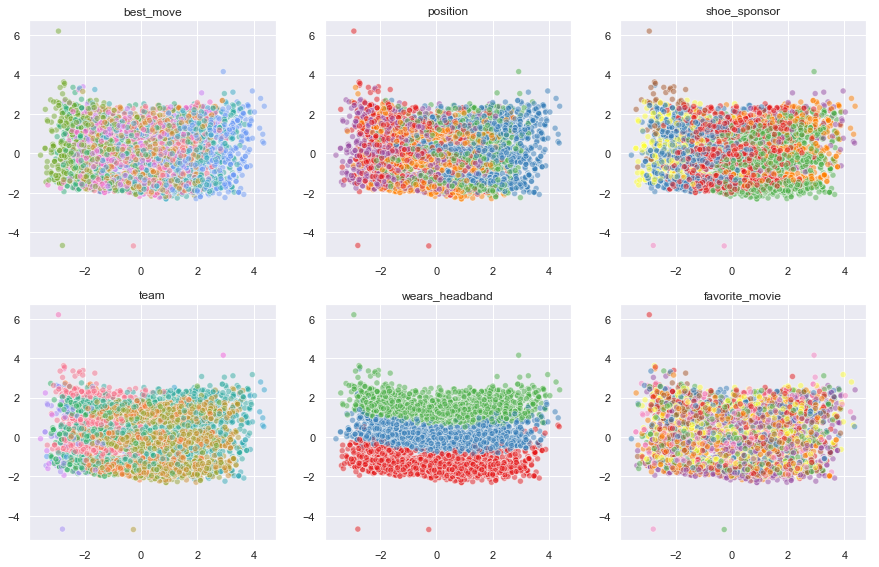

In [62]:
sns.set_palette("Set1")
fig = plt.figure(figsize=[15,20])
for i,col in enumerate(df.columns[1:]):
    fig.add_subplot(4,3,i+1)
    sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=df[col], 
                    alpha=.5, legend=False)
    plt.title(col)
plt.show()

# MCA

In [23]:
mca = prince.MCA(n_components=10)
mca.fit(Xcat)

MCA(check_input=True, copy=True, engine='auto', n_components=10, n_iter=10,
  random_state=None)

In [24]:
mca.total_inertia_

7.333333333333333

In [25]:
print([round(x,2) for x in mca.explained_inertia_])
print(np.sum(mca.explained_inertia_))

[0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
0.27283322085804135


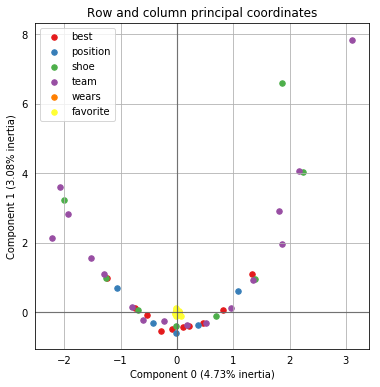

In [26]:
ac = mca.plot_coordinates(X=Xcat,
     ax=None,
     figsize=(6, 6),
     show_row_points=False,
     row_points_size=1,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1)

In [27]:
mca_components = mca.transform(Xcat)
mca_components.head()

,0,1,2,3,4,5,6,7,8,9
0,0.523845,0.391000,0.414976,-0.056332,0.566753,-0.494997,-0.456446,0.164754,-0.099950,-0.242239
1,0.330964,-0.262864,0.211806,0.136086,-0.246754,-0.406658,-0.267307,-0.235107,0.136540,0.020879
2,-0.495080,-0.122822,0.332907,-0.487071,0.130247,-0.355293,0.314569,0.177255,-0.089818,-0.074788
3,-0.388817,-0.407169,0.506398,0.453717,0.246670,-0.536848,-0.006616,0.013492,0.227736,0.185438
4,0.491016,-0.047656,-0.059560,-0.159790,0.111302,-0.010872,-0.067458,0.180507,0.024101,-0.856382


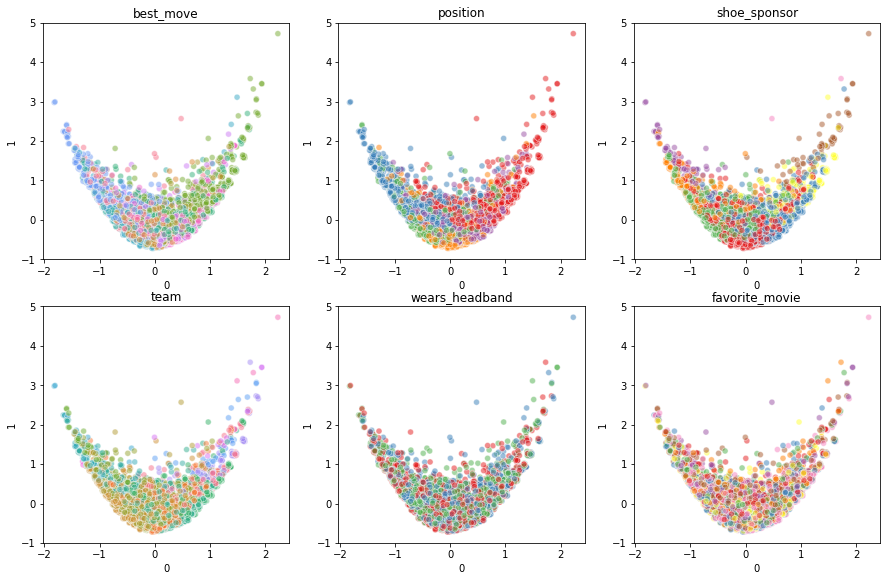

In [28]:
sns.set_palette("Set1")
fig = plt.figure(figsize=[15,20])
for i,col in enumerate(df.columns[1:]):
    fig.add_subplot(4,3,i+1)
    sns.scatterplot(x=mca_components[0], y=mca_components[1], hue=df[col], 
                    alpha=.5, legend=False)
    plt.title(col)
plt.show()

Guttman Effect: First dimension has found a linear relationship, and the second is separating high and low outliers from the rest of the items.

# Comparing them both with a simple regression

In [29]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(
    pca_components, y, test_size=0.33)

mca_X_train, mca_X_test, mca_y_train, mca_y_test = train_test_split(
    mca_components, y, test_size=0.33)

In [30]:
#PCA:
regr.fit(pca_X_train, pca_y_train)
print(regr.score(pca_X_train, pca_y_train))
print(regr.score(pca_X_test, pca_y_test))

0.7990211452397301
0.8011294248926508


In [31]:
#MCA:
regr.fit(mca_X_train, mca_y_train)
print(regr.score(mca_X_train, mca_y_train))
print(regr.score(mca_X_test, mca_y_test))

0.8615467970327627
0.8658446353947272


In [32]:
def anova_viz(oneHotDf, comp1, comp2):
    results = []
    for cat in oneHotDf.columns:
        #set up temporary dataframe for easy slicing
        df = pd.DataFrame({
            cat : oneHotDf[cat],
            'comp1': comp1,
            'comp2': comp2
        })
        #First dimension
        mean_tot = df['comp1'].mean()
        mean_negs = df[df[cat]==0]['comp1'].mean()
        mean_pos = df[df[cat]==1]['comp1'].mean()
        count_negs = df[df[cat]==0]['comp1'].count()
        count_pos = df[df[cat]==1]['comp1'].count()
        top = count_negs*(mean_negs-mean_tot)**2 + count_pos*(mean_pos-mean_tot)**2
        bottom = np.sum([(x-mean_tot)**2 for x in df['comp1']])
        p1 = top/bottom
        #Second Dimension
        mean_tot = df['comp2'].mean()
        mean_negs = df[df[cat]==0]['comp2'].mean()
        mean_pos = df[df[cat]==1]['comp2'].mean()
        count_negs = df[df[cat]==0]['comp2'].count()
        count_pos = df[df[cat]==1]['comp2'].count()
        top = count_negs*(mean_negs-mean_tot)**2 + count_pos*(mean_pos-mean_tot)**2
        bottom = np.sum([(x-mean_tot)**2 for x in df['comp2']])
        p2 = top/bottom
        #Store
        results.append((cat, p1, p2))
    rdf = pd.DataFrame(results, columns=['label','dim1','dim2'])
    plt.figure(figsize=[15,15])
    fig = sns.scatterplot(x='dim1', y='dim2', hue='label',
                          data=rdf, legend=False, s=200)
    for point in range(0,rdf.shape[0]):
        fig.text(rdf.dim1[point]+0.005, rdf.dim2[point], 
        rdf.label[point], horizontalalignment='left', 
            size='medium', color='grey', weight='semibold')
    plt.show()
    return rdf

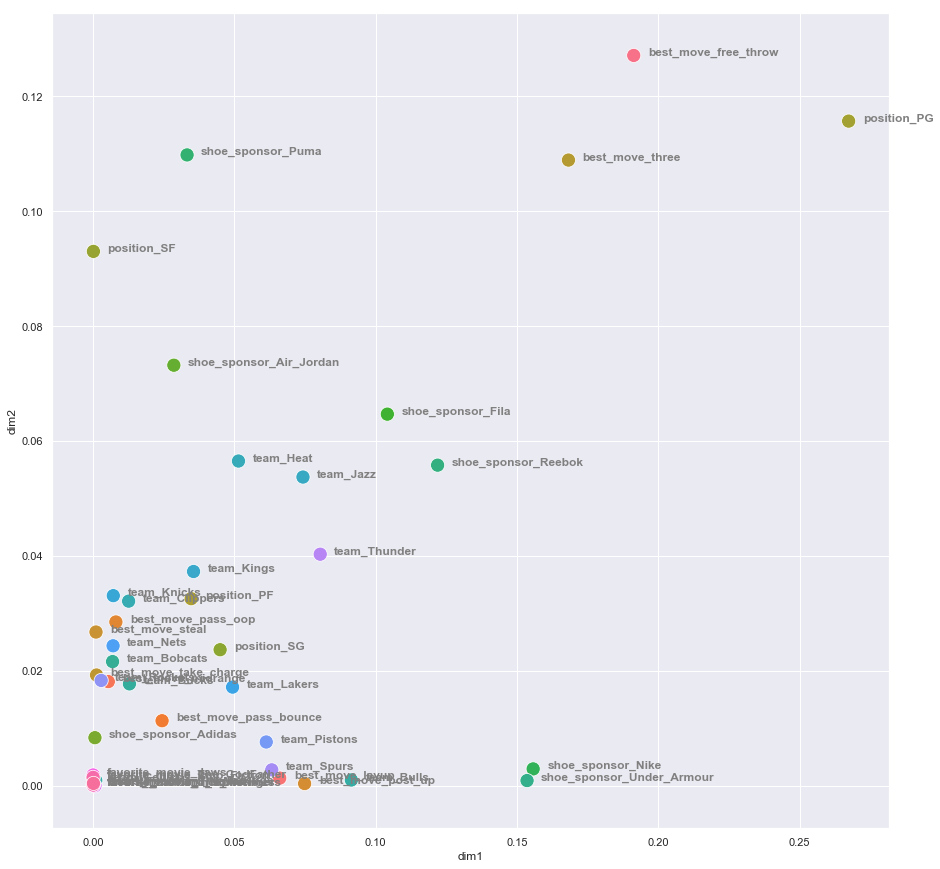

In [33]:
sns.set()
mca_anova = anova_viz(X,mca_components[0],mca_components[1])

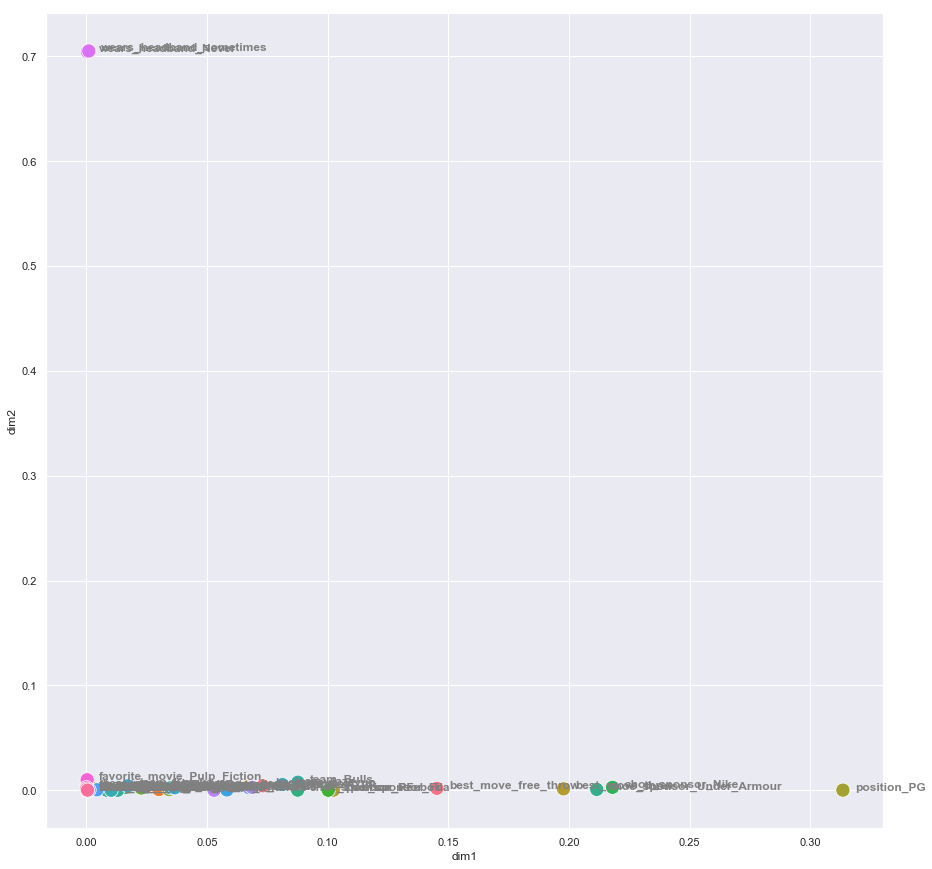

In [34]:
pca_anova = anova_viz(X,pca_components[:,0], pca_components[:,1])

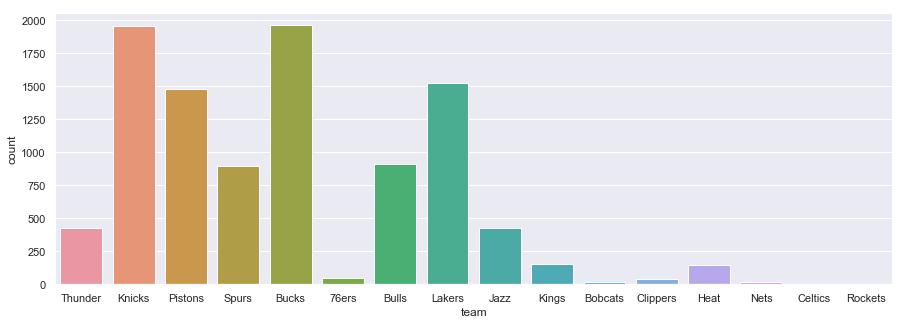

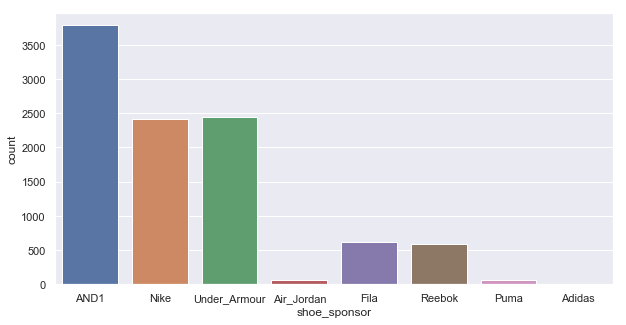

In [35]:
plt.figure(figsize=[15,5])
sns.countplot(df.team)
plt.show()
plt.figure(figsize=[10,5])
sns.countplot(df.shoe_sponsor)
plt.show()

### Covariance matrix

In [36]:
print(scaledX.shape)
Xt = scaledX.T
print(Xt.shape)

(10000, 44)
(44, 10000)


In [37]:
Cx = np.cov(Xt)
print(len(Cx))
print(len(Cx[0]))

44
44


In [38]:
np.set_printoptions(precision=3)
print('Covariance Matrix:\n', np.round(Cx,3))

Covariance Matrix:
 [[ 1.    -0.113 -0.109 ...  0.    -0.011 -0.009]
 [-0.113  1.    -0.114 ... -0.018  0.021 -0.016]
 [-0.109 -0.114  1.    ...  0.01  -0.016  0.013]
 ...
 [ 0.    -0.018  0.01  ...  1.    -0.143 -0.14 ]
 [-0.011  0.021 -0.016 ... -0.143  1.    -0.141]
 [-0.009 -0.016  0.013 ... -0.14  -0.141  1.   ]]


In [39]:
np.round(np.diag(Cx),1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
product = np.matmul(Xt,scaledX)